# 预训练

镜像获取：

https://support.huaweicloud.com/usermanual-standard-modelarts/docker-modelarts_6022.html

```shell
docker pull swr.cn-southwest-2.myhuaweicloud.com/atelier/pytorch_2_1_ascend:pytorch_2.1.0-cann_8.0.rc1-py_3.9-euler_2.10.7-aarch64-snt9b-20240521222801-f4f5b88

docker run -it --privileged --name=llm -u root --net=host --ipc=host \
--device=/dev/davinci0 \
--device=/dev/davinci1 \
--device=/dev/davinci2 \
--device=/dev/davinci3 \
--device=/dev/davinci4 \
--device=/dev/davinci5 \
--device=/dev/davinci6 \
--device=/dev/davinci7 \
--device=/dev/davinci_manager \
--device=/dev/devmm_svm \
--device=/dev/hisi_hdc \
-v /usr/local/Ascend/driver:/usr/local/Ascend/driver \
-v /usr/local/Ascend/add-ons/:/usr/local/Ascend/add-ons/ \
-v /usr/local/sbin/:/usr/local/sbin/ \
-v /var/log/npu/slog/:/var/log/npu/slog \
-v /var/log/npu/profiling/:/var/log/npu/profiling \
-v /var/log/npu/dump/:/var/log/npu/dump \
-v /var/log/npu/:/usr/slog \
-v /etc/hccn.conf:/etc/hccn.conf \
-v /home/icbc:/mnt \
-w /mnt \
a66637dc4410 \
/bin/bash

```

### 1 数据预览

In [3]:
! head -2 wikipedia-zh-cn-8192.jsonl

{"id": "13", "title": "数学", "tags": "", "text": "数学是研究数量、结构以及空间等概念及其变化的一门学科，属于形式科学的一种。数学利用抽象化和逻辑推理，从计数、计算、量度、对物体形状及运动的观察发展而成。数学家们拓展这些概念，以公式化新的猜想，以及从选定的公理及定义出发，严谨地推导出一些定理。\n基础数学的知识与运用是生活中不可或缺的一环。对数学基本概念的完善，早在古埃及、美索不达米亚及古印度历史上的古代数学文本便可观见，而在古希腊那里有更为严谨的处理。从那时开始，数学的发展便持续不断地小幅进展，至16世纪的文艺复兴时期，因为新的科学发现和数学革新两者的交互，致使数学的加速发展，直至今日。数学并成为许多国家及地区的教育中的一部分。\n数学在许多领域都有应用，包括科学、工程、医学、经济学和金融学等。数学对这些领域的应用通常被称为应用数学，有时亦会激起新的数学发现，并导致全新学科的发展，例如物理学的实质性发展中建立的某些理论激发数学家对于某些问题的不同角度的思考。数学家也研究纯粹数学，就是数学本身的实质性内容，而不以任何实际应用为目标。许多研究虽然以纯粹数学开始，但其过程中也发现许多可用之处。\n词源.\n西方语言中“数学”（）一词源自于古希腊语的（），其有“学习”、“学问”、“科学”，还有个较狭义且技术性的意思－「数学研究」，即使在其语源内。其形容词（），意思为「和学习有关的」或「用功的」，亦会被用来指「数学的」。其在英语中表面上的复数形式，及在法语中的表面复数形式'，可溯至拉丁文的中性复数'，由西塞罗译自希腊文复数（），此一希腊语被亚里士多德拿来指「万物皆数」的概念。\n汉字表示的「数学」一词大约产生于中国宋元时期。多指象数之学，但有时也含有今天上的数学意义，例如，秦九韶的《数学九章》（《永乐大典》记，即《数书九章》也被宋代周密所著的《癸辛杂识》记为《数学大略》）、《数学通轨》（明代柯尚迁著）、《数学钥》（清代杜知耕著）、《数学拾遗》（清代丁取忠撰）。直到1939年，经过中国数学名词审查委员会研究“算学”与“数学”两词的使用状况后，确认以“数学”表示今天意义上的数学含义。\n历史.\n数学有着久远的历史。它被认为起源于人类早期的生产活动：中国古代的六艺之一就有「数」，数学一词在西方有希腊语词源（mathematikós）

### 2 工具安装

```shell
git pull https://gitee.com/janelu9/EasyLLM
cd EasyLLM
pip wheel -e . --no-deps && pip install jllm-*-py3-none-any.whl
```

In [12]:
#!pip install jllm-3.2.4.tar.gz

### 3 数据转换

In [5]:
!python -m jllm.raw2ids \
    --tokenizer Qwen2.5-7B-Instruct \
    -i wikipedia-zh-cn-512.jsonl \
    --max_len 8193 \
    -t pretrain --stack -C 
# --stack 拼接token凑成max_len的长度，减少pad_id; 
# -C 清除缓存重新转换 

Namespace(t='pretrain', i='wikipedia-zh-cn-512.jsonl', o='', n=8388608, c='gzip', batch_size=65536, max_len=8193, cores=-1, max_num=1, max_pixels=2073600, tokenizer='Qwen2.5-7B-Instruct', image_path='', tmp='tmp', stack=True, T=False, C=True, pad=False, filter=False)
/mnt
########## begine converting pretrain data with 204 executors.###########
258it [00:06, 39.14it/s]
/mnt/tmp/wikipedia-zh-cn-512-00000 stored in parquet with 258 samples
/mnt/wikipedia-zh-cn-512.jsonl has been converted into /mnt/wikipedia-zh-cn-512_Qwen2.5-7B-Instruct successfully!


### 3.1 数据检查(可选步骤)

In [6]:
from transformers import AutoTokenizer
import pyarrow.parquet

In [7]:
tokenizer=AutoTokenizer.from_pretrained('Qwen2.5-7B-Instruct')

In [8]:
data = pyarrow.parquet.read_table('wikipedia-zh-cn-512_Qwen2.5-7B-Instruct/wikipedia-zh-cn-512-00000')

In [9]:
input_ids =data['input_ids'].to_numpy().tolist()

In [10]:
idx=0

In [11]:
print(tokenizer.decode(input_ids[idx]))

<|im_start|>数学是研究数量、结构以及空间等概念及其变化的一门学科，属于形式科学的一种。数学利用抽象化和逻辑推理，从计数、计算、量度、对物体形状及运动的观察发展而成。数学家们拓展这些概念，以公式化新的猜想，以及从选定的公理及定义出发，严谨地推导出一些定理。
基础数学的知识与运用是生活中不可或缺的一环。对数学基本概念的完善，早在古埃及、美索不达米亚及古印度历史上的古代数学文本便可观见，而在古希腊那里有更为严谨的处理。从那时开始，数学的发展便持续不断地小幅进展，至16世纪的文艺复兴时期，因为新的科学发现和数学革新两者的交互，致使数学的加速发展，直至今日。数学并成为许多国家及地区的教育中的一部分。
数学在许多领域都有应用，包括科学、工程、医学、经济学和金融学等。数学对这些领域的应用通常被称为应用数学，有时亦会激起新的数学发现，并导致全新学科的发展，例如物理学的实质性发展中建立的某些理论激发数学家对于某些问题的不同角度的思考。数学家也研究纯粹数学，就是数学本身的实质性内容，而不以任何实际应用为目标。许多研究虽然以纯粹数学开始，但其过程中也发现许多可用之处。
词源.
西方语言中“数学”（）一词源自于古希腊语的（），其有“学习”、“学问”、“科学”，还有个较狭义且技术性的意思－「数学研究」，即使在其语源内。其形容词（），意思为「和学习有关的」或「用功的」，亦会被用来指「数学的」。其在英语中表面上的复数形式，及在法语中的表面复数形式'，可溯至拉丁文的中性复数'，由西塞罗译自希腊文复数（），此一希腊语被亚里士多德拿来指「万物皆数」的概念。
汉字表示的「数学」一词大约产生于中国宋元时期。多指象数之学，但有时也含有今天上的数学意义，例如，秦九韶的《数学九章》（《永乐大典》记，即《数书九章》也被宋代周密所著的《癸辛杂识》记为《数学大略》）、《数学通轨》（明代柯尚迁著）、《数学钥》（清代杜知耕著）、《数学拾遗》（清代丁取忠撰）。直到1939年，经过中国数学名词审查委员会研究“算学”与“数学”两词的使用状况后，确认以“数学”表示今天意义上的数学含义。
历史.
数学有着久远的历史。它被认为起源于人类早期的生产活动：中国古代的六艺之一就有「数」，数学一词在西方有希腊语词源（mathematikós），意思是“学问的基础”，源于（máthema，“科学，知识，学问”）。
史前的人类就已尝

### 4 模型训练

#### 注: NPU下使用张量并行(model_parallel_size>1)需要Megatron和MindSpeed。

```shell
# 获取megatron
git clone https://github.com/NVIDIA/Megatron-LM.git
cd Megatron-LM
git checkout core_r0.6.0
cp -r megatron ../
# 安装mindspeed
git clone https://gitee.com/ascend/MindSpeed.git
cd MindSpeed
# checkout commit from MindSpeed core_r0.6.0 in 0923
git checkout 4ea42a23 
pip install -r requirements.txt 
pip3 install -e .
cd ..
```

In [3]:
!deepspeed --module jllm.train_pipe \
    --model Qwen2.5-7B-Instruct \
    --num_train_epochs 1 \
    --train_data wikipedia-zh-cn-512_Qwen2.5-7B-Instruct \
    --pipe_parallel_size 2 \
    --model_parallel_size 2 \
    --sequence_parallel_size 2 \
    --per_device_train_batch_size 1 \
    --gradient_accumulation_steps 16 \
    --partition_method fast \
    --output_dir pretrained \
    --max_num_checkpoints 2 \
    --split_dlayer \
    --low_mem \
    --learning_rate 1e-5 |tee pretrain.log
#注释：
# --model 模型路径至少需要包含config.json
# --num_train_epochs 训练轮数
# --train_data 训练数据
# --pipe_parallel_size 流水线并行个数
# --model_parallel_size 张量并行个数
# --per_device_train_batch_size 一次训练多少样本
# --gradient_accumulation_steps 训练完多少样本后（累加完多少个梯度后）进行一次参数更新
# --partition_method fast 流水线拆分策略
# --checkpoint checkpoint 模型检查点目录
# --output_dir pretrained 最终模型输出目录
# --max_num_checkpoints 2 最大保留多少个检查点
# --split_dlayer 是否拆分docoder layer
# --low_mem 是否使用低内存读取数据
# --learning_rate 1e-5 学习率

[2024-11-27 17:06:32,774] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to npu (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-devel package with yum
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
[2024-11-27 17:06:34,204] [WARNING] [runner.py:212:fetch_hostfile] Unable to find hostfile, will proceed with training with local resources only.
[2024-11-27 17:06:34,204] [INFO] [runner.py:585:main] cmd = /home/ma-user/anaconda3/envs/PyTorch-2.1.0/bin/python3.9 -u -m deepspeed.launcher.launch --world_info=eyJsb2NhbGhvc3QiOiBbMCwgMSwgMiwgMywgNCwgNSwgNiwgN119 --master_addr=127.0.0.1 --master_port=29500 --module --enable_each_rank_log=None jllm.train_pipe --model Qwen2.5-7B-Instruct --num_train_epochs 1 --train_data wikipedia-zh-cn-512_Qwen2.5-7B-Instruct --pipe_

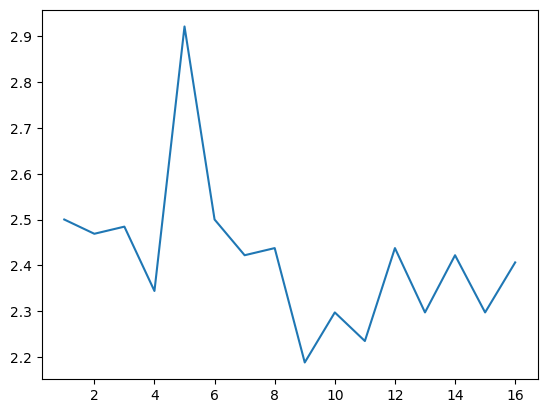

In [4]:
!grep  'steps:.*loss:' pretrain.log|awk '{print $2,$4}'>pretrain.loss
import matplotlib.pyplot as plt
import numpy as np
xy=np.loadtxt('pretrain.loss')  
plt.plot(xy[:,0], xy[:,1])  
plt.show()

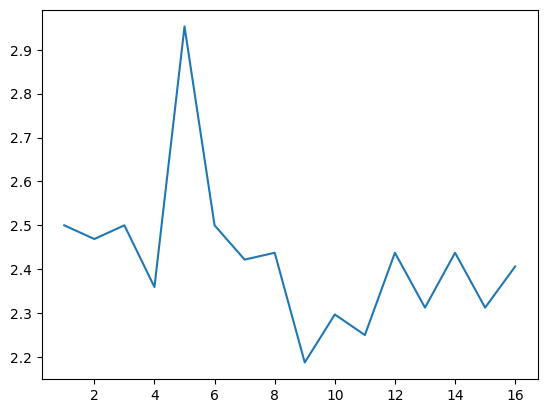

In [2]:
!grep  'steps:.*loss:' pretrain.log|awk '{print $2,$4}'>pretrain.loss
import matplotlib.pyplot as plt
import numpy as np
xy=np.loadtxt('pretrain.loss')  
plt.plot(xy[:,0], xy[:,1])  
plt.show()

##### 正常情况下形如：

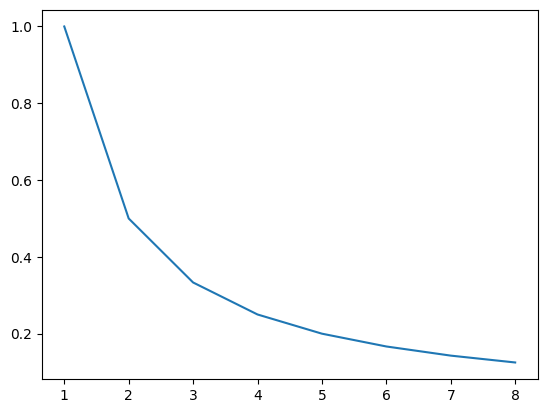

In [14]:
plt.plot(xy[:,0], 1/xy[:,0])  
plt.show()

### 5 参数转换

#### 5.1 checkpoint转huggingface

In [15]:
!deepspeed --module jllm.train_pipe \
    --model Qwen2.5-7B-Instruct \
    --train_data wikipedia-zh-cn-512_Qwen2.5-7B-Instruct \
    --pipe_parallel_size 2 \
    --model_parallel_size 2 \
    --partition_method fast \
    --split_dlayer \
    --num_train_epochs 0 \
    --from_ckpt checkpoint \
    --output_dir pretrained
#--model 模型路径
#--train_data 训练数据
#--pipe_parallel_size 流水线长度
#--partition_method 流水线拆分方法
#--split_dlayer 将decoder layer拆开,使流水线分布更均匀
#--from_ckpt 加载模型参数的checkpoint路径
#--output_dir  输出huggingface格式模型的路径

[2024-11-11 22:43:35,757] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to npu (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-devel package with yum
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
[2024-11-11 22:43:37,166] [WARNING] [runner.py:212:fetch_hostfile] Unable to find hostfile, will proceed with training with local resources only.
[2024-11-11 22:43:37,167] [INFO] [runner.py:585:main] cmd = /home/ma-user/anaconda3/envs/PyTorch-2.1.0/bin/python3.9 -u -m deepspeed.launcher.launch --world_info=eyJsb2NhbGhvc3QiOiBbMCwgMSwgMiwgMywgNCwgNSwgNiwgN119 --master_addr=127.0.0.1 --master_port=29500 --module --enable_each_rank_log=None jllm.train_pipe --model Qwen2.5-7B-Instruct --train_data wikipedia-zh-cn-512_Qwen2.5-7B-Instruct --pipe_parallel_size 2 --mod

#### 5.2 合并拆分张量(model_parallel_size>2)

In [16]:
!python -m jllm.cat2hf \
    -C pretrained 
# -C 合并前的模型路径
# -H 合并后的huggingface格式的模型路径。不填的自行创建为pretrained_hf

100%|█████████████████████████████████████████| 177/177 [00:03<00:00, 55.44it/s]
Done!


### 6 模型测试

In [15]:
from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer=AutoTokenizer.from_pretrained('Qwen2.5-7B-Instruct')

In [16]:
model = AutoModelForCausalLM.from_pretrained(
    'pretrained_hf',
    torch_dtype="auto",
    device_map="auto"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
text='数学是研究数量、结构以及空间等概念及其变化的一门学科，属于'

In [18]:
from time import time

In [19]:
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
st=time()
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=128
)
du=time()-st
tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
[W VariableFallbackKernel.cpp:51] Warning: CAUTION: The operator 'aten::isin.Tensor_Tensor_out' is not currently supported on the NPU backend and will fall back to run on the CPU. This may have performance implications. (function npu_cpu_fallback)


'数学是研究数量、结构以及空间等概念及其变化的一门学科，属于形式科学的一种。数学是人类对事物的抽象结构与模式进行严格描述的一种通用手段，可以应用于现实世界的任何问题。数学家和哲学家对数学的确切范围和定义有一系列的看法。数学在人类历史发展和社会生活中发挥着不可替代的作用，也是学习和研究现代科学技术必不可少的基本工具。数学是研究数量、结构、变化、空间以及信息等概念的一门学科，从某种角度看属于形式科学的一种。数学家和哲学家对数学的确切范围和定义有一系列的看法。而在人类历史发展和社会生活中，数学也发挥着不可替代的作用，也是学习和研究'

In [20]:
128/du

7.7173362469042015